In [2]:
# Task 4: Predict CNA Impact (Extra Credit)

import scanpy as sc
import pandas as pd
import gseapy as gp
from matplotlib import pyplot as plt

In [3]:
# Load the AnnData object output from Task 3
adata = sc.read_h5ad(r"C:\Users\LENOVO\Documents\pyfiles_cscb_fin\task3_ad_def_final_with_cnas.h5ad")

# Save a copy of CNA results from Task 3 (if stored in .obs or .uns)
adata.obs.to_csv("task3_cell_annotations.csv")
if "cna_regions" in adata.uns:
    pd.DataFrame(adata.uns["cna_regions"]).to_csv("task3_cna_regions.csv", index=False)

In [5]:
# Create simplified CNA label column if not present
def simplify_cna_label(x):
    if isinstance(x, str):
        if 'gain' in x:
            return 'gain'
        elif 'loss' in x:
            return 'loss'
        else:
            return 'none'
    return 'none'

if 'cna_status' not in adata.obs.columns:
    adata.obs['cna_status'] = adata.obs['detect_CNA'].apply(simplify_cna_label)

In [6]:
# Step 1: Subset the cells with gain vs. normal (no CNA)
gain_cells = adata[adata.obs['cna_status'] == 'gain']
normal_cells = adata[adata.obs['cna_status'] == 'none']

In [7]:
# Step 2: Compute differential expression (DEG) between gain and normal
sc.tl.rank_genes_groups(adata, groupby='cna_status', reference='none', method='wilcoxon')

# Step 3: Extract DEGs for enrichment analysis
ranked_genes = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['gain'],
    'score': adata.uns['rank_genes_groups']['scores']['gain']
})
ranked_genes = ranked_genes.dropna()

In [8]:
# Step 4: Save ranked genes for reproducibility
ranked_genes.to_csv("ranked_genes_gain_vs_normal.csv", index=False)

# Step 5: Run GSEA using pre-ranked list (e.g. with GO_Biological_Process_2021)
pre_res = gp.prerank(
    rnk=ranked_genes,
    gene_sets='GO_Biological_Process_2021',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27112\1075426383.py:5: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
2025-05-07 17:11:01,627 [WARNING] Duplicated values found in preranked stats: 48.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Available columns in GSEA result: Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')


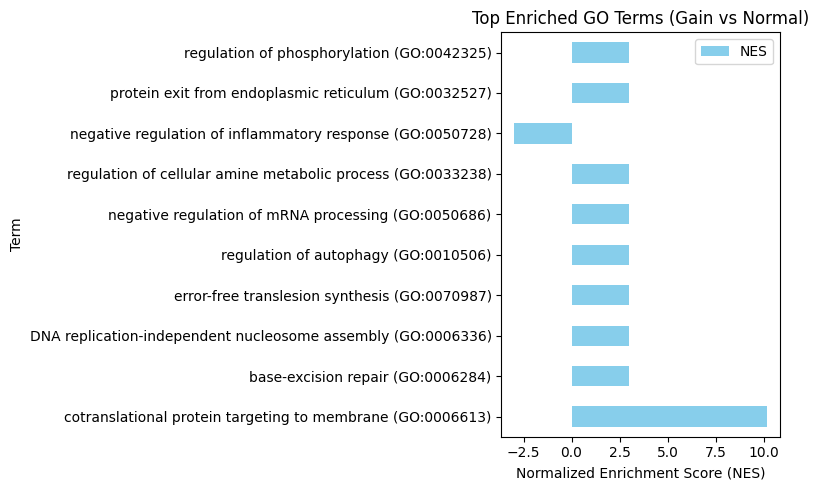

In [10]:
# Step 6: Plot top GSEA results
# Fix: Use correct FDR column name if not 'fdr'
print("Available columns in GSEA result:", pre_res.res2d.columns)
sort_col = 'Adjusted P-value' if 'Adjusted P-value' in pre_res.res2d.columns else ('FDR q-val' if 'FDR q-val' in pre_res.res2d.columns else 'fdr')
pre_res.res2d.sort_values(sort_col, inplace=True)
pre_res.res2d.head(10).plot.barh(y='NES', x='Term', figsize=(8,5), color='skyblue')
plt.xlabel('Normalized Enrichment Score (NES)')
plt.title('Top Enriched GO Terms (Gain vs Normal)')
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27112\157880701.py:27: DeprecationWarning: processes is deprecated; use threads
  pre_res_loss = gp.prerank(
2025-05-07 17:15:52,915 [WARNING] Duplicated values found in preranked stats: 11.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Available columns in GSEA result (loss): Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')


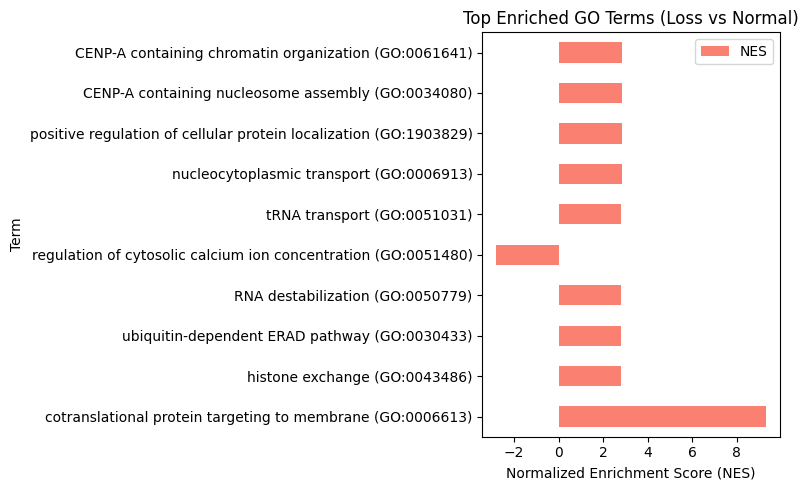

In [13]:
# Optional: Save results
pre_res.res2d.to_csv("cna_gain_vs_normal_gsea.csv")

# Step 7: Repeat for loss vs normal
# Subset cells for loss vs none
loss_cells = adata[adata.obs['cna_status'] == 'loss']
none_cells = adata[adata.obs['cna_status'] == 'none']

# Temporarily relabel for loss analysis
adata.obs['cna_temp'] = adata.obs['cna_status'].astype(str)
# Temporarily relabel for loss analysis
adata.obs['cna_temp'] = adata.obs['cna_status'].astype(str)
adata.obs.loc[adata.obs['cna_temp'] == 'gain', 'cna_temp'] = 'other'  # exclude gain from current comparison

# Run DEG for loss vs none
sc.tl.rank_genes_groups(adata, groupby='cna_temp', reference='none', method='wilcoxon')

# Extract DEGs for enrichment analysis
ranked_genes_loss = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['loss'],
    'score': adata.uns['rank_genes_groups']['scores']['loss']
})
ranked_genes_loss = ranked_genes_loss.dropna()
ranked_genes_loss.to_csv("ranked_genes_loss_vs_normal.csv", index=False)

# Run GSEA for loss
pre_res_loss = gp.prerank(
    rnk=ranked_genes_loss,
    gene_sets='GO_Biological_Process_2021',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)

# Plot top GSEA results for loss
print("Available columns in GSEA result (loss):", pre_res_loss.res2d.columns)
sort_col_loss = 'Adjusted P-value' if 'Adjusted P-value' in pre_res_loss.res2d.columns else ('FDR q-val' if 'FDR q-val' in pre_res_loss.res2d.columns else 'fdr')
pre_res_loss.res2d.sort_values(sort_col_loss, inplace=True)
pre_res_loss.res2d.head(10).plot.barh(y='NES', x='Term', figsize=(8,5), color='salmon')
plt.xlabel('Normalized Enrichment Score (NES)')
plt.title('Top Enriched GO Terms (Loss vs Normal)')
plt.tight_layout()
plt.show()

# Save results for loss
pre_res_loss.res2d.to_csv("cna_loss_vs_normal_gsea.csv")

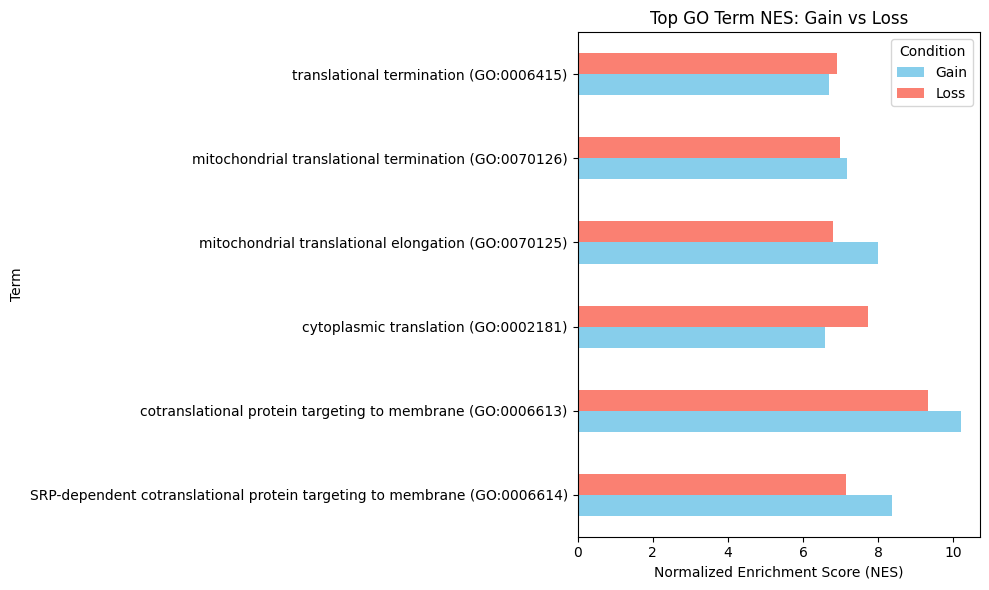

In [14]:
# Step 8: Combine top terms from gain and loss for side-by-side NES comparison
# Get top 10 terms from each
gain_top = pre_res.res2d.sort_values(sort_col).head(10).copy()
gain_top['Condition'] = 'Gain'
loss_top = pre_res_loss.res2d.sort_values(sort_col_loss).head(10).copy()
loss_top['Condition'] = 'Loss'

# Merge and pivot
combined = pd.concat([gain_top, loss_top])
combined_pivot = combined.pivot(index='Term', columns='Condition', values='NES').dropna()

# Plot
combined_pivot.plot(kind='barh', figsize=(10, 6), color={"Gain": "skyblue", "Loss": "salmon"})
plt.xlabel("Normalized Enrichment Score (NES)")
plt.title("Top GO Term NES: Gain vs Loss")
plt.tight_layout()
plt.show()

# Save combined NES table
combined_pivot.to_csv("combined_gain_loss_top10_nes.csv")